In [1]:
import numpy as np
import pandas as pd

import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
import datetime
import scipy as sp
import utm

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Import the data

In [2]:
pd_dataset = None
pd_dataset = pd.read_csv(r"374281000.csv")

# Subsample the data before any conversion

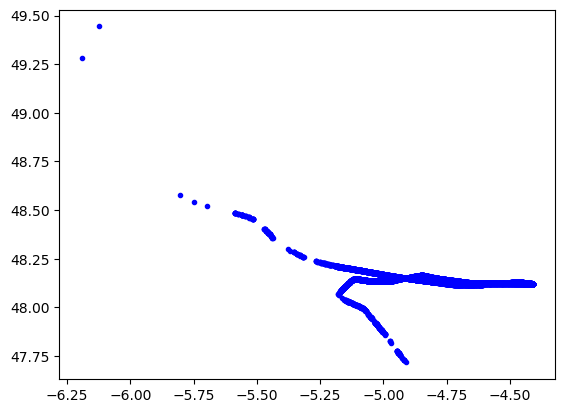

In [3]:
#print(pd_dataset.sort_values(by = 'datetimestamp', ascending = True ))
plt.plot(pd_dataset['long'],pd_dataset['lat'], 'b.')
plt.show()

# Subsampling time intervals

In [4]:
def subsample_obs_time(df_in, time_interval_sec, obs_per_interval):

    obs = obs_per_interval
    time_inteval = time_interval_sec

    #Max and min time
    maxtime = max(df_in['datetimestamp'].values)
    mintime = min(df_in['datetimestamp'].values)

    #Total number of time sections in the data
    total_iter = int(maxtime/time_inteval) +1

    #start interval, inclusive
    lowerbound = mintime 
    #initial size, exclusive
    upperbound = time_inteval 

    #Result DATAFRAME
    df_sub_result = df_in.copy(deep = True)
    df_sub_result = df_sub_result.iloc[0:0] #drop all entries in the dataframe

    for subset_walk in np.arange(1,total_iter+2,1):#each subset present
        boolean_selection = ((lowerbound < df_in['datetimestamp']) & (df_in['datetimestamp'] <= upperbound)).values

        #subset for this interval
        time_subset = copy.deepcopy(df_in.iloc[boolean_selection,:])

        # subsampling the time sibset
        if obs < len(time_subset): #if the no of observations is lessthat the total in the timestep continue, else nothing
            for subsample in np.arange(0,len(time_subset), obs): #step with size = obs to sample each value in the set
                df_sub_result = df_sub_result.append(time_subset.iloc[subsample,:])


        #update bounds
        #start interval, inclusive
        lowerbound = copy.deepcopy(upperbound)
        upperbound = time_inteval*subset_walk

    return df_sub_result

In [5]:
#df_sampled = subsample_obs_time(pd_dataset, 60, 3)
df_sampled = pd_dataset

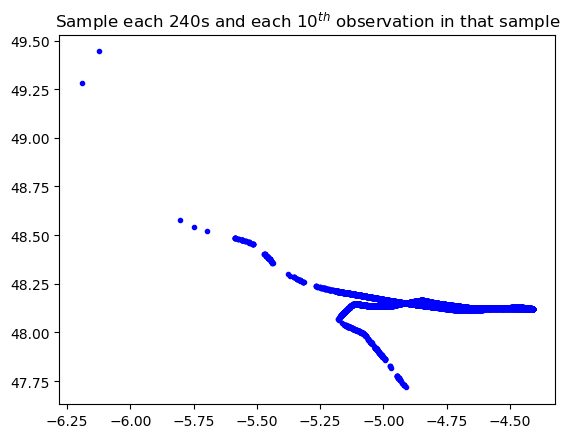

6762
6762


In [6]:
plt.plot(df_sampled['long'],df_sampled['lat'],  'b.')
plt.title("Sample each 240s and each $10^{th}$ observation in that sample")
plt.show()


print(len(df_sampled))
print(len(pd_dataset))

# Kalman -Conversions

In [7]:
def convert_cog(data_in):
    return (data_in)*np.pi/180 #convert to radians

def convert_rot(data_in):
    return (data_in/60)*np.pi/180 #rad per second
    
def convert_sog(data_in):
    return data_in*0.5144444444 #meter per second

def convert_dataset(data_in, time_interval_sub, each_obs_sub):
    #Converting time date:
    df_sorted = copy.deepcopy(data_in.sort_values(by = 'datetimestamp', ascending = True ))
    #Getting the date of the first observation
    first_obs_date = df_sorted.iloc[0,6]

    #Subtracting the dates to get the seconds from start to finish
    df_sorted['datetimestamp'] = ((pd.to_datetime(df_sorted['datetimestamp']) - pd.to_datetime(first_obs_date)).dt.total_seconds())

    #Sub sample time interval in seconds, after dates has been converted to startin at 0 sec to 5000s (example)
    test = subsample_obs_time(df_sorted, time_interval_sub, each_obs_sub)
    df_sorted = copy.deepcopy(test)
    

    #Conversion of Course over ground
    df_sorted['cog'] = convert_cog(df_sorted['cog'])
    
    #Convert Speed over ground to mps
    df_sorted['sog'] = convert_sog(df_sorted['sog'])
    
    #Convert rate of turn 
    df_sorted['rot'] = convert_rot(df_sorted['rot'])
    
    #Making the order same as testset    
    df_sorted = df_sorted[['datetimestamp', 'lat', 'long', 'cog', 'sog','rot']]
    
    # Caluclating the the cartesian coordinates
    X = []
    Y = []
    
    #initial cartesian
    init_utm = utm.from_latlon(df_sorted['lat'].values[0], df_sorted['long'].values[0])
    X.append(init_utm[0])   #adding X coordinate
    Y.append(init_utm[1])   #Adding Y coordinate

    delta_time = [] #calculating delta time
    delta_time.append(0)
    for i in np.arange(1, len(df_sorted['datetimestamp']),1):
        delta_time.append(int(df_sorted['datetimestamp'].values[i]) - int(df_sorted['datetimestamp'].values[i-1]))
        #Caclulcating coordinates
        ans = utm.from_latlon(df_sorted['lat'].values[i], df_sorted['long'].values[i])
        #Adding the cartesian coordinates per time step
        X.append(copy.deepcopy(ans[0]))
        Y.append(copy.deepcopy(ans[1]))
    
   
    #Adding the delta time
    df_sorted.insert(1,'deltatime',delta_time) 
    #Adding cartesian coordiantes
    df_sorted['lat'] = Y
    df_sorted['long'] = X
   
    return df_sorted
    
    

## Kalman Filter

In [8]:
def get_mat_A(deltaTime):
    A = np.identity(4)
    A[0,2] = deltaTime
    A[1,3] = deltaTime
    return A

def predict_state(A, X_prev, a_x, a_y, deltaTIME):
        
    Bu_k = np.array([[a_x*deltaTIME*deltaTIME/2],
                     [a_y*deltaTIME*deltaTIME/2],
                     [a_x*deltaTIME],
                     [a_y*deltaTIME]])
    
    pred_state = A.dot(X_prev) + Bu_k
    return pred_state

def pred_err_cov(A, Pk, Q):
    return A.dot(Pk).dot(np.transpose(A)) + Q

def Kalman_gain(P_k, H, R):
    above = P_k.dot(np.transpose(H))
    bottom = np.linalg.inv(H.dot(P_k).dot(np.transpose(H)) + R)
    return above.dot(bottom)

def adjust_pred_state(pred_state, Kk,z_k,H):
    #Where z_k == the real observed value to adjust for the errors made
    return pred_state + Kk.dot(z_k - H.dot(pred_state))

def update_err_cov(I,Kk,H,P_k):
    return (I - Kk.dot(H)).dot(P_k)    

def calc_a_xy(arr_in, arr_prev):
    
    sog_now = np.around(arr_in[5],8)
    sog_prev = np.around(arr_prev[5],8)
    
    cog_now = np.around(arr_in[4],8)
    cog_prev = np.around(arr_prev[4],8)
    
    rot_now = np.around(arr_in[6],6)    
    delta_time = arr_in[1]   
    a_x = (sog_now*np.cos(cog_now + rot_now*delta_time) - sog_prev*np.cos(cog_prev))/delta_time    
    a_y = (sog_now*np.sin(cog_now + rot_now*delta_time) - sog_prev*np.sin(cog_prev))/delta_time 
    
    return a_x, a_y


def convert_state(arr_in):
    sog = arr_in[5]
    cog = arr_in[4]    
    x = arr_in[2]
    y = arr_in[3]        
    Vx = sog*np.cos(cog)
    Vy = sog*np.sin(cog)
    
    return_arr = np.array([[x],[y],[Vx],[Vy]])
    
    return return_arr

def extract_long_lat_covariance(mat_in):
    Var1 = mat_in[0,0]
    Var2 = mat_in[1,1]
    Cov12 = mat_in[0,1]
    
    result = np.array([[Var1,Cov12],[Cov12,Var2]])
    return result

## Implementing Kalman

In [9]:
ax_arr = []
ay_arr= []
Pk_save_states = []
realSpdCount = []
def myKalman(pd_final, R,Q,P_k):
    global ax_arr, ay_arr, df_final,Pk_save_states,realSpdCount
    realSpdCount = []
    
    H = np.identity(4)
    I = np.identity(4)   

    lat_AVG = np.average(pd_final['lat'].values[0:3])
    long_AVG = np.average(pd_final['long'].values[0:3])
    # Kalman Initial state
    X_state = np.array([[lat_AVG],[long_AVG],[0],[0]])
    X_state = np.array([[0],[0],[0],[0]])
    
    
    
    
    # Lists to append data and values to, saving ttansitions:
    ax_arr = []
    ay_arr = []
    X_save_states = []
    Pk_save_states = []
    Pk_save_states.append(copy.deepcopy(P_k))

    data_counter = 1 # counter for the original data set obsevations

    max_time = int(max(pd_final.iloc[:,0]))
    min_time = int(min(pd_final.iloc[:,0]))

    data_counter_stop = max_time-min_time
    
    realSpeedX = []
    realSpeedY = []
    realSpdCount = []
    for i in np.arange(0,max_time,1):

        '''If we observe the value we observe this'''
        if(i == 0 or (int(pd_final.iloc[data_counter,0]) == i and data_counter < data_counter_stop)):
            zk_prev = pd_final.iloc[data_counter-1,:].values #previous observation
            z_k = pd_final.iloc[data_counter,:].values # convert to numpy array -observed value

            delta_TIME = copy.deepcopy(z_k[1]) #difference in time
            A = get_mat_A(delta_TIME)

            #Acceleration
            ax, ay = calc_a_xy(z_k,zk_prev) 
            ax_arr.append(ax)
            ay_arr.append(ay)

            z_k = copy.deepcopy(convert_state(z_k)) #convert state
            realSpdCount.append(i)
            realSpeedX.append(z_k[2][0])
            realSpeedY.append(z_k[3][0])
            X_state = copy.deepcopy(convert_state(zk_prev))

            #Kalman Predict--------------------------------------------------------------------------------------------
            X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, delta_TIME))
            P_k =  copy.deepcopy(pred_err_cov(A, P_k, Q))

            #Kalman Measuremenet update--------------------------------------------------------------------------------
            Kalman_k = copy.deepcopy(Kalman_gain(P_k, H, R))
            X_state = copy.deepcopy(adjust_pred_state(X_state, Kalman_k, z_k, H))
            P_k = copy.deepcopy(update_err_cov(I, Kalman_k, H, P_k))


            #increment counter
            data_counter += 1

            #Saving states
            X_save_states.append(copy.deepcopy(X_state))
            Pk_save_states.append(copy.deepcopy(P_k))

        else:
            '''This code will be excecuted when we have no observation'''
            ay = 0
            ax = 0
            A = get_mat_A(1)
            #Kalman Predict --------------------------------------------------------------------------
            X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, 1))
            P_k =  copy.deepcopy(pred_err_cov(A,P_k,Q))

            #Saving states
            Pk_save_states.append(copy.deepcopy(P_k))
            X_save_states.append(copy.deepcopy(X_state))



    # Saving the coordinates:
    X_coord = []
    Y_coord = []
    Pk_coord  = []
    SpeedX = []
    SpeedY = []
    

    for i in range(0,len(X_save_states)):
        if i > 1 and  i % 1 == 0:
            X_coord.append(X_save_states[i][0][0])
            Y_coord.append(X_save_states[i][1][0])
            SpeedX.append(X_save_states[i][2][0]) #Speed in X axis
            SpeedY.append(X_save_states[i][3][0]) #Speed in Y axis
            
            #Pk_coord.append(extract_long_lat_covariance(Pk_save_states[i]))

    #Extracting the original data:
    X_orig = copy.deepcopy(pd_final.iloc[:,2])
    Y_orig = copy.deepcopy(pd_final.iloc[:,3])

    plt.plot(np.arange(0,len(SpeedX),1), SpeedX, 'b-')
    plt.plot(realSpdCount, realSpeedX,'r-')
    plt.title("Linear Speed in X")
    plt.show()
    
    plt.plot(np.arange(0,len(SpeedY),1),SpeedY)
    plt.plot(realSpdCount, realSpeedY,'r-')
    plt.title("Linear Speed in Y")
    plt.show()
    
    
    
    plt.plot(realSpdCount,Y_orig[0:(len(realSpdCount))], "rx")
    plt.plot(np.arange(0,len(Y_coord),1),Y_coord, "bx")
    plt.title("X pred (red) vs original (blue)")
    plt.show()
    
    plt.plot(realSpdCount,X_orig[0:(len(realSpdCount))], "rx")
    plt.plot(np.arange(0,len(X_coord),1),X_coord, "bx")
    plt.title("Y pred (red) vs original (blue)")
    plt.show()

   
    return X_coord,Y_coord,X_orig,Y_orig,ax_arr,ay_arr, SpeedX, SpeedY


In [10]:
pd_dataset = None
pd_dataset = pd.read_csv(r"538004506.csv")
pd_dataset.head()

,mmsi,lat,long,sog,rot,cog,datetimestamp
0,538004506,47.856000,-5.358498,8.3,0,23,22/10/2015 02:01:26
1,538004506,47.950670,-5.337832,7.7,0,2,22/10/2015 02:46:47
2,538004506,47.951332,-5.337832,7.6,0,2,22/10/2015 02:47:05
3,538004506,47.967500,-5.338998,8.0,0,355,22/10/2015 02:54:36
4,538004506,48.012665,-5.345165,7.6,0,353,22/10/2015 03:15:57


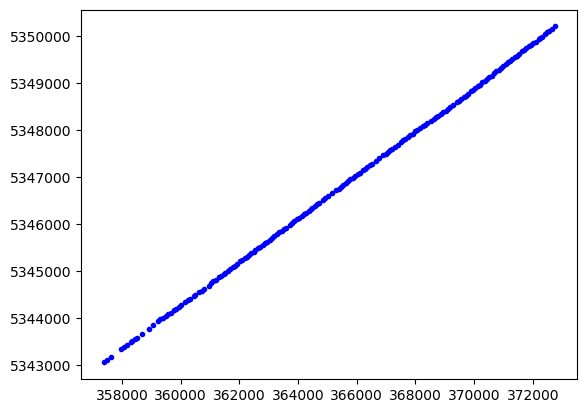

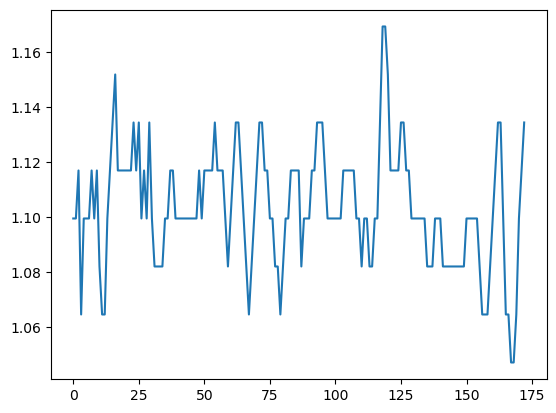

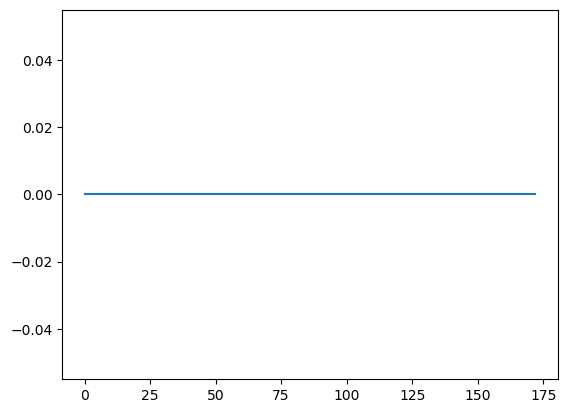

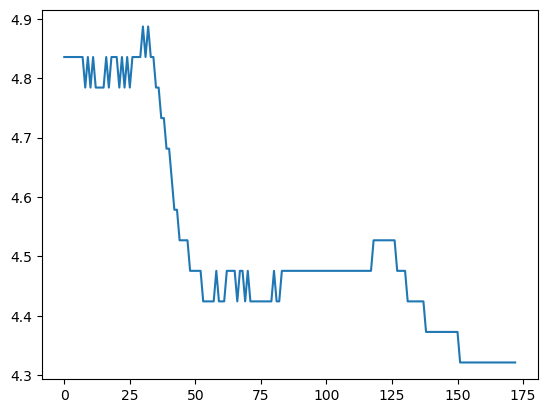

1      0.0
3      0.0
5      0.0
7      0.0
9      0.0
      ... 
330    0.0
332    0.0
334    0.0
336    0.0
338    0.0
Name: rot, Length: 173, dtype: float64
1.10359287211364


In [11]:
lower = 10 #750
upper = 350

myrange = np.arange(lower,upper,1)

pd_dataset_new = convert_dataset(pd_dataset.iloc[myrange,:].reset_index(drop = True),240,2)


df_sampled = pd_dataset_new
plt.plot(df_sampled['long'],df_sampled['lat'],'b.')
plt.show()

plt.plot(np.arange(0,len(pd_dataset_new),1), pd_dataset_new['cog'])
plt.show()
plt.plot(np.arange(0,len(pd_dataset_new),1), pd_dataset_new['rot'])
plt.show()

plt.plot(np.arange(0,len(pd_dataset_new),1), pd_dataset_new['sog'])
plt.show()
print(pd_dataset_new['rot'])
print(np.average(pd_dataset_new['cog']))

# Setting up $P_k$

In [12]:
var_X = np.sqrt(np.var(df_sampled['lat'][0:10]))
var_Y = np.sqrt(np.var(df_sampled['long'][0:10]))

# var_spdX = np.sqrt(np.var(SpdX[0:10]))
# var_spdY = np.sqrt(np.var(SpdY[0:10]))
var_spdX = 0
var_spdY = 0

var_X = 10
var_Y = 10

# var_spdX = np.sqrt(np.var(SpdX[0:10]))
# var_spdY = np.sqrt(np.var(SpdY[0:10]))
var_spdX = 0.3
var_spdY = 0.3

P_k = np.array([[var_X],[var_Y],[var_spdX],[var_spdY]]).dot(np.transpose(
      np.array([[var_X],[var_Y],[var_spdX],[var_spdY]])))
print(P_k)

[[1.e+02 1.e+02 3.e+00 3.e+00]
 [1.e+02 1.e+02 3.e+00 3.e+00]
 [3.e+00 3.e+00 9.e-02 9.e-02]
 [3.e+00 3.e+00 9.e-02 9.e-02]]


# Setting up $Q$:



In [13]:
# var_X = np.sqrt(np.var(df_sampled['lat'][0:10]))
# var_Y = np.sqrt(np.var(df_sampled['long'][0:10]))
# # var_spdX = np.sqrt(np.var(SpdX[0:500]))
# # var_spdY = np.sqrt(np.var(SpdY[0:500]))

# var_spdX = 0
# var_spdY = 0


Q = np.array([[var_X],[var_Y],[var_spdX],[var_spdY]]).dot(np.transpose(
      np.array([[var_X],[var_Y],[var_spdX],[var_spdY]])))
print(Q)

[[1.e+02 1.e+02 3.e+00 3.e+00]
 [1.e+02 1.e+02 3.e+00 3.e+00]
 [3.e+00 3.e+00 9.e-02 9.e-02]
 [3.e+00 3.e+00 9.e-02 9.e-02]]


# Setting up R:


In [14]:
R = np.diag(np.array([1000,2000,0.1,0.1]))
R = np.diag(np.diag(P_k))

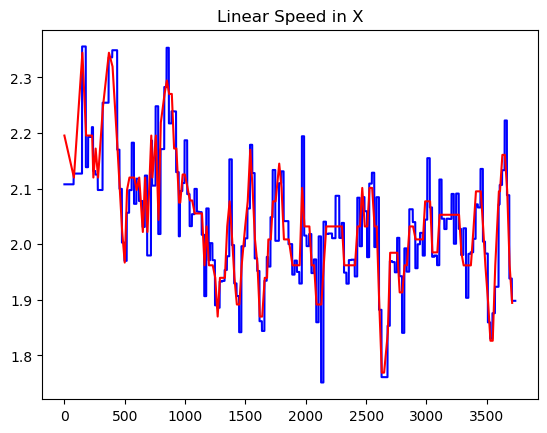

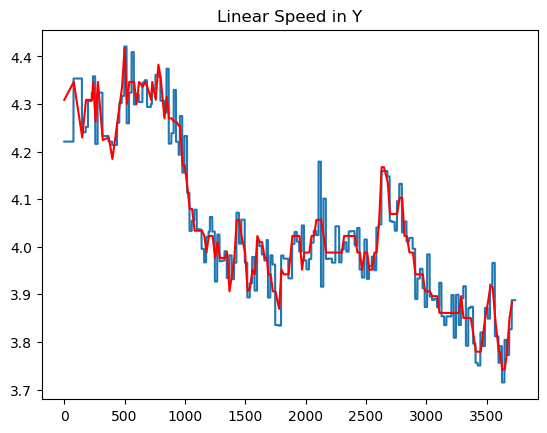

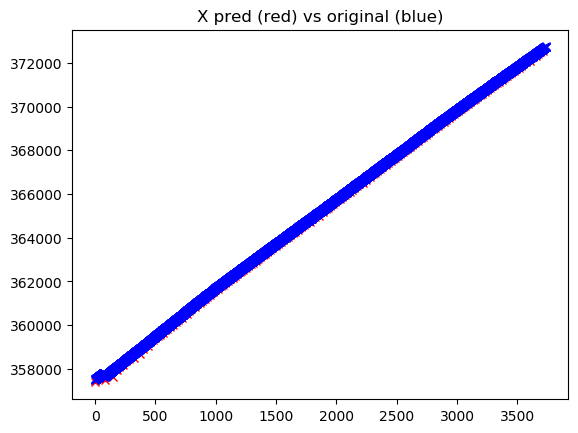

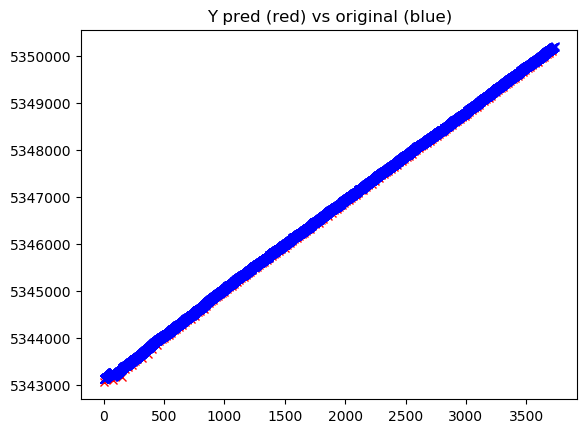

In [15]:
X_samp_pred, Y_samp_pred, X_samp_orig, Y_samp_orig, axx, ayy, SpdX,SpdY = myKalman(df_sampled, R,Q,P_k)

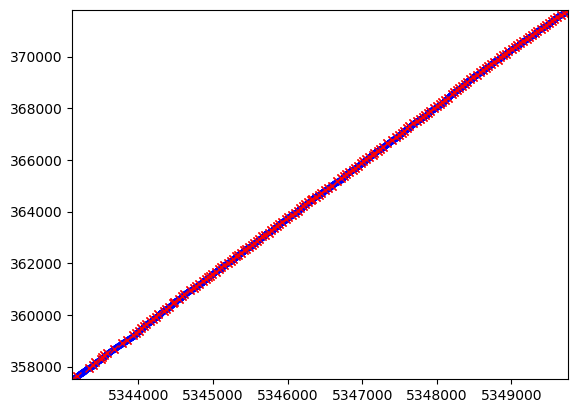

In [16]:
X_samp_pred = np.array(X_samp_pred)
Y_samp_pred = np.array(Y_samp_pred)
X_samp_orig = np.array(X_samp_orig)
Y_samp_orig = np.array(Y_samp_orig)

closer_look = np.arange(0,3500,1)
plt.plot(X_samp_pred[closer_look], Y_samp_pred[closer_look], "b.")
plt.plot(X_samp_orig, Y_samp_orig, "rx")

plt.plot(X_samp_pred ,Y_samp_pred, "b.")
plt.plot(X_samp_orig, Y_samp_orig, "rx")


plt.xlim(min(X_samp_pred[closer_look]),max(X_samp_pred[closer_look]))
plt.ylim(min(Y_samp_pred[closer_look]),max(Y_samp_pred[closer_look]))

plt.show()

# XY kalman Error

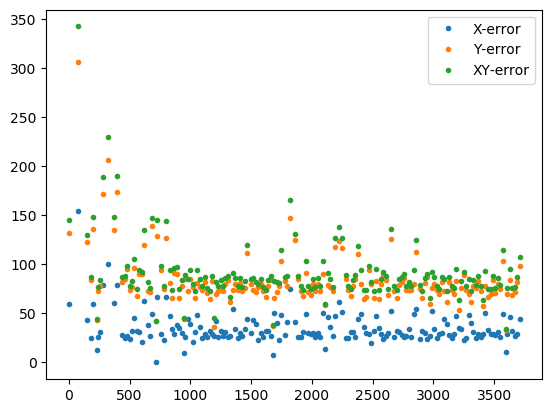

In [17]:
#X_samp_pred, Y_samp_pred, X_samp_orig, Y_samp_orig, axx, ayy, SpdX,SpdY = myKalma

X_error = X_samp_orig[2:len(X_samp_orig)] - X_samp_pred[realSpdCount]
Y_error = Y_samp_orig[2:(len(X_samp_orig))] - Y_samp_pred[realSpdCount]
#X_samp_pred

XY_error = np.sqrt(X_error**2 + Y_error**2)
plt.plot(realSpdCount,X_error,'.')
plt.plot(realSpdCount,Y_error,'.')
plt.plot(realSpdCount,XY_error,'.')

legend_lab = ["X-error","Y-error","XY-error"]
plt.legend(legend_lab, loc = "best")

plt.show()

# Y_samp_pred[realSpdCount]

# Linear Implementation

### This will be a function of time
We will be estimating X Y SpeedOverGround CourseOverGround. With this we can calculate the speed in the X and Y axis respectively.

#### Idea:
$X_{new} =  X_{old} + Speed_{x-axis} \times time$

$Y_{new} =  Y_{old} + Speed_{y-axis} \times time$


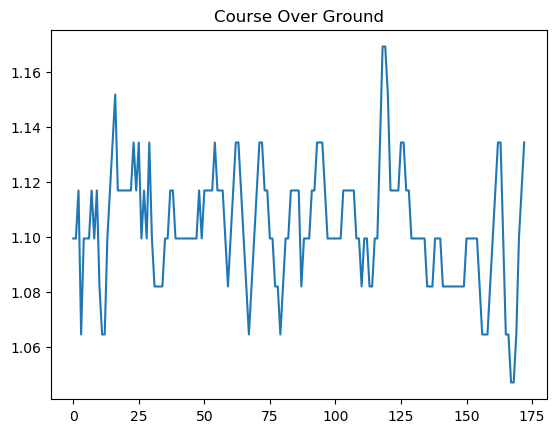

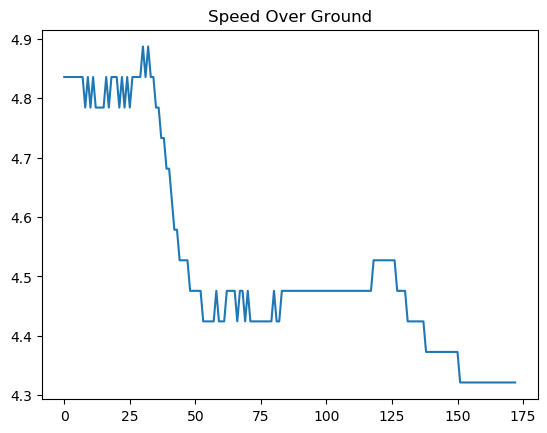

In [18]:
df_mmsi = copy.deepcopy(pd_dataset_new)

plt.plot(np.arange(0,len(df_mmsi),1), df_mmsi['cog'])
plt.title("Course Over Ground")
plt.show()
# plt.plot(np.arange(0,len(pd_dataset_new),1), pd_dataset_new['rot'])
# plt.title("Rate of Turn")
# plt.show()

plt.plot(np.arange(0,len(df_mmsi),1), df_mmsi['sog'])
plt.title("Speed Over Ground")
plt.show()

In [19]:
df_mmsi['datetimestamp'].values

array([  19.,   49.,   79.,  149.,  180.,  199.,  230.,  240.,  259.,
        279.,  319.,  369.,  399.,  440.,  459.,  479.,  500.,  519.,
        539.,  560.,  579.,  599.,  620.,  650.,  669.,  688.,  720.,
        729.,  758.,  780.,  799.,  830.,  849.,  868.,  890.,  909.,
        928.,  950.,  960.,  980.,  998., 1020., 1040., 1059., 1080.,
       1100., 1118., 1140., 1161., 1178., 1198., 1209., 1229., 1250.,
       1270., 1289., 1310., 1330., 1349., 1369., 1390., 1409., 1429.,
       1450., 1469., 1498., 1519., 1540., 1559., 1579., 1600., 1619.,
       1639., 1660., 1679., 1690., 1710., 1728., 1750., 1780., 1799.,
       1819., 1859., 1890., 1910., 1929., 1949., 1970., 1989., 2009.,
       2030., 2049., 2069., 2089., 2109., 2129., 2149., 2170., 2189.,
       2220., 2249., 2280., 2300., 2319., 2339., 2359., 2379., 2408.,
       2429., 2449., 2468., 2489., 2510., 2528., 2550., 2570., 2588.,
       2609., 2630., 2649., 2680., 2699., 2718., 2740., 2759., 2778.,
       2800., 2819.,

In [20]:
import numpy as np
from sklearn.linear_model import LinearRegression

1.0995574287564276


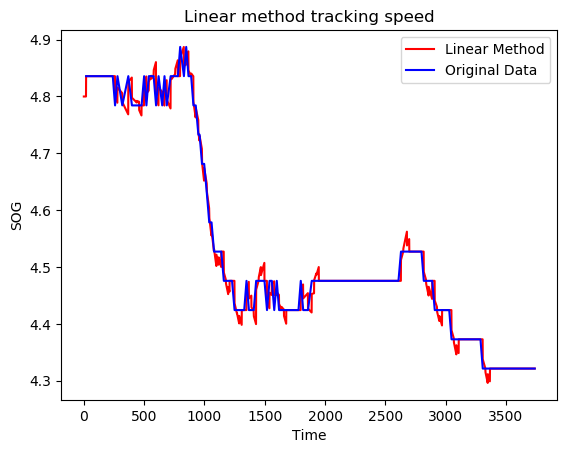

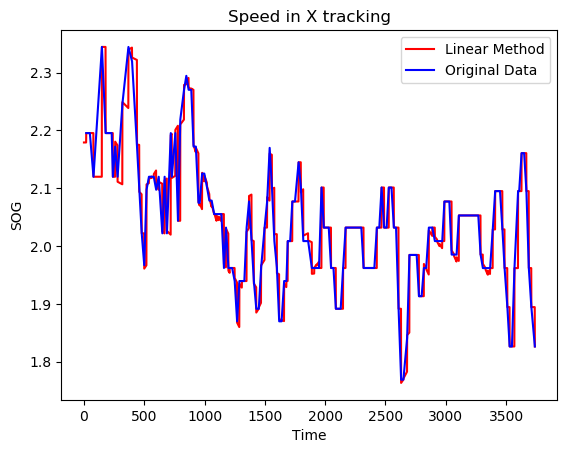

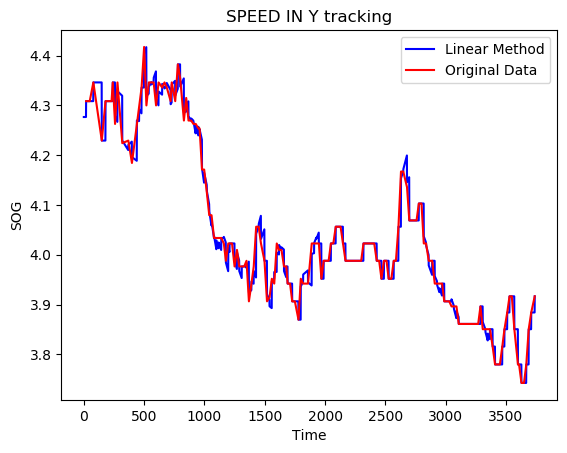

In [69]:
time = df_mmsi['datetimestamp'].values.astype(int) #exctracting time as an array
#Time range in seconds
sec_range = np.arange(0,int(max(time))+1,1)
#Extracting speed
speed = df_mmsi['sog'].values
course = df_mmsi['cog'].values

current_course = course[0] #initial course value. It remains constant only update if a new value comes
print(current_course)

#To save historical times
time_history = np.array([]) # thislist will keep track of the last times recorded, intitial time == 0
speed_history = np.array([]) # this list keep track of the speeds recorded
pred_speed = np.array([]) # this list stores the predicted values

#Speed in X Y
pred_speedX =  []
pred_speedY = []
orig_speedX = []
orig_speedY = []

#Saving prediction
speed_pred = []

# REMEMBER HISTORY OF MODEL
remember_history = 3


#Initial Regression guess
reg = LinearRegression()
reg.fit(np.array([0]).reshape(-1,1),np.array([4.8]).reshape(-1,1))

counter_sec = 0 #counting the entries to appropriatly measure difference
for sec in sec_range:    
    '''IF WE OBSERVE the value'''
    if(time[counter_sec] == sec):
        
        if len(time_history) > remember_history : #if the list is long enough
            speed_history = np.delete(speed_history,0) #remove 1st entry in array
            time_history = np.delete(time_history,0) # remove 1st entry in array
            
            
        #Saving the last moments up to specified history amount    
        time_history = np.append(time_history,sec)
        speed_history = np.append(speed_history,speed[counter_sec])
        current_course =  course[counter_sec]
        
        

        #Fit a new model
        reg = LinearRegression()
        reg.fit(time_history.reshape(-1,1),speed_history.reshape(-1,1))
        
        #PREDICTING SPEED
        predict_speed_value = reg.predict(np.array([sec]).reshape(-1,1))
        pred_speed = np.append(pred_speed,predict_speed_value)
        
        #SPEED IN X AN Y AXIS
        pred_speedX.append(predict_speed_value[0][0]*np.cos(current_course))
        pred_speedY.append(predict_speed_value[0][0]*np.sin(current_course))
        
        
        orig_speedX.append(speed[counter_sec]*np.cos(course[counter_sec]))
        orig_speedY.append(speed[counter_sec]*np.sin(course[counter_sec]))
        
        #Counter to walk through list
        counter_sec += 1   
        
    else:
        #JUST PERDICT
        predict_speed_value = reg.predict(np.array([sec]).reshape(-1,1))
        #SPEED
        pred_speed = np.append(pred_speed, predict_speed_value)
        #SPEED IN X AN Y AXIS
        pred_speedX.append(predict_speed_value[0][0]*np.cos(current_course))
        pred_speedY.append(predict_speed_value[0][0]*np.sin(current_course))




# PLOTTING
plt.plot(sec_range,pred_speed,'r-')
plt.plot(time,speed,"b-")
legend_data = ["Linear Method", "Original Data"]
plt.legend(legend_data,loc = 'best')
plt.title("Linear method tracking speed")
plt.ylabel("SOG")
plt.xlabel("Time")
plt.show()

#print(pred_speedX)
plt.plot(sec_range,np.array(pred_speedX),'r-')
plt.plot(time,np.array(orig_speedX),'b-')
legend_data = ["Linear Method", "Original Data"]
plt.legend(legend_data,loc = 'best')
plt.title("Speed in X tracking")
plt.ylabel("SOG")
plt.xlabel("Time")
plt.show()


plt.plot(sec_range,np.array(pred_speedY),'r-')
plt.plot(time,np.array(orig_speedY),'b-')
legend_data = ["Linear Method", "Original Data"]
plt.legend(legend_data,loc = 'best')
plt.title("SPEED IN Y tracking")
plt.ylabel("SOG")
plt.xlabel("Time")
plt.show()


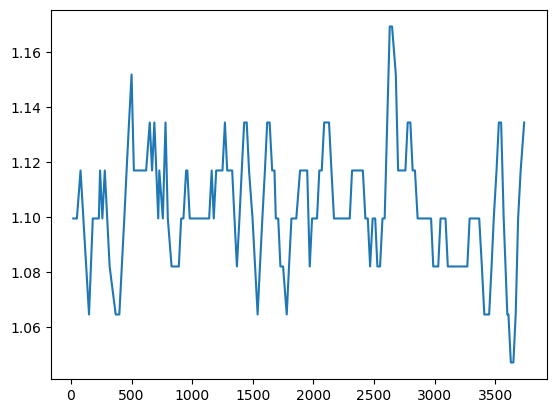

In [43]:
plt.plot(time,course)
plt.show()

In [23]:
predict_list = []
predict_list.append(1)
predict_list.append(2)
predict_list.append(3)
predict_list.append(4)
predict_list.append(5)

In [24]:
predict_list

[1, 2, 3, 4, 5]

In [25]:
predict_list.pop(0) #remove 1st obj

1

In [26]:
predict_list

[2, 3, 4, 5]

In [27]:
counter_sec = 0 #counting the entries
time = df_mmsi['datetimestamp'].values.astype(int) #exctracting time as an array

speed = df_mmsi['sog'].values


for sec in range(0,int(max(time))+1,1):    
    '''IF WE OBSERVE the value'''
    if(time[counter_sec] == sec):
        
        
        
        
        counter_sec += 1        
